In [1]:
%store -r core_area core_meanlon core_meanlat df_lifetime df

In [44]:
# Import libraries

import numpy as np
import rasterio
import pandas as pd
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [69]:
# Extract longitudes and latitudes for each class 

# Open the geotiff file
with rasterio.open("../data/Houston.tif") as src:
    # Read the image data into a 2D numpy array
    image = src.read(1)
    # Get the transformation matrix of the image
    transform = src.transform

# Create a dictionary to store the coordinates for each class
coordinates_by_class = {}

# For each unique value in the image (which represents a class)
for class_value in np.unique(image):
    # If the value is not 0 (0 typically represents no data)
    if class_value != -1:
        # Get the indices of the pixels that belong to this class
        indices = np.where(image == class_value)
        # Convert the indices to coordinates
        coordinates = [transform * (x, y) for x, y in zip(*indices)]
        # Store the coordinates in the dictionary
        coordinates_by_class[class_value] = coordinates

# Now `coordinates_by_class` is a dictionary where the keys are the classes and the values
# are lists of (longitude, latitude) tuples for each pixel in that class.



In [71]:
core_area_pd = pd.read_csv('../data/core_area_1.csv')

# Assuming you have the 'coordinates_by_class' and 'core_area_pd' as provided in your code

# Create KDTree for df_core_areas to perform nearest-neighbor search
df_core_areas = core_area_pd[['Longitude', 'Latitude', 'core_area']]
tree = cKDTree(df_core_areas[['Longitude', 'Latitude']].values)

# Loop over the keys (classes) in coordinates_by_class
for class_num in range(1, 17):
    # Create Pandas DataFrame for the current class
    df_coords = pd.DataFrame(coordinates_by_class[class_num], columns=['Longitude', 'Latitude'])
    
    # Find the index of the nearest neighbor in df_core_areas for each point in df_coords
    _, idx = tree.query(df_coords[['Longitude', 'Latitude']].values)
    
    # Merge based on the nearest-neighbor index
    merged_df = df_coords.join(df_core_areas.iloc[idx][['core_area']].reset_index(drop=True))
    
    # Save the result DataFrame to a CSV file
    merged_df.to_csv(f'../data/LCZ_classes/class{class_num}.csv', index=False)


# Spatial variation of core area for each LCZ class

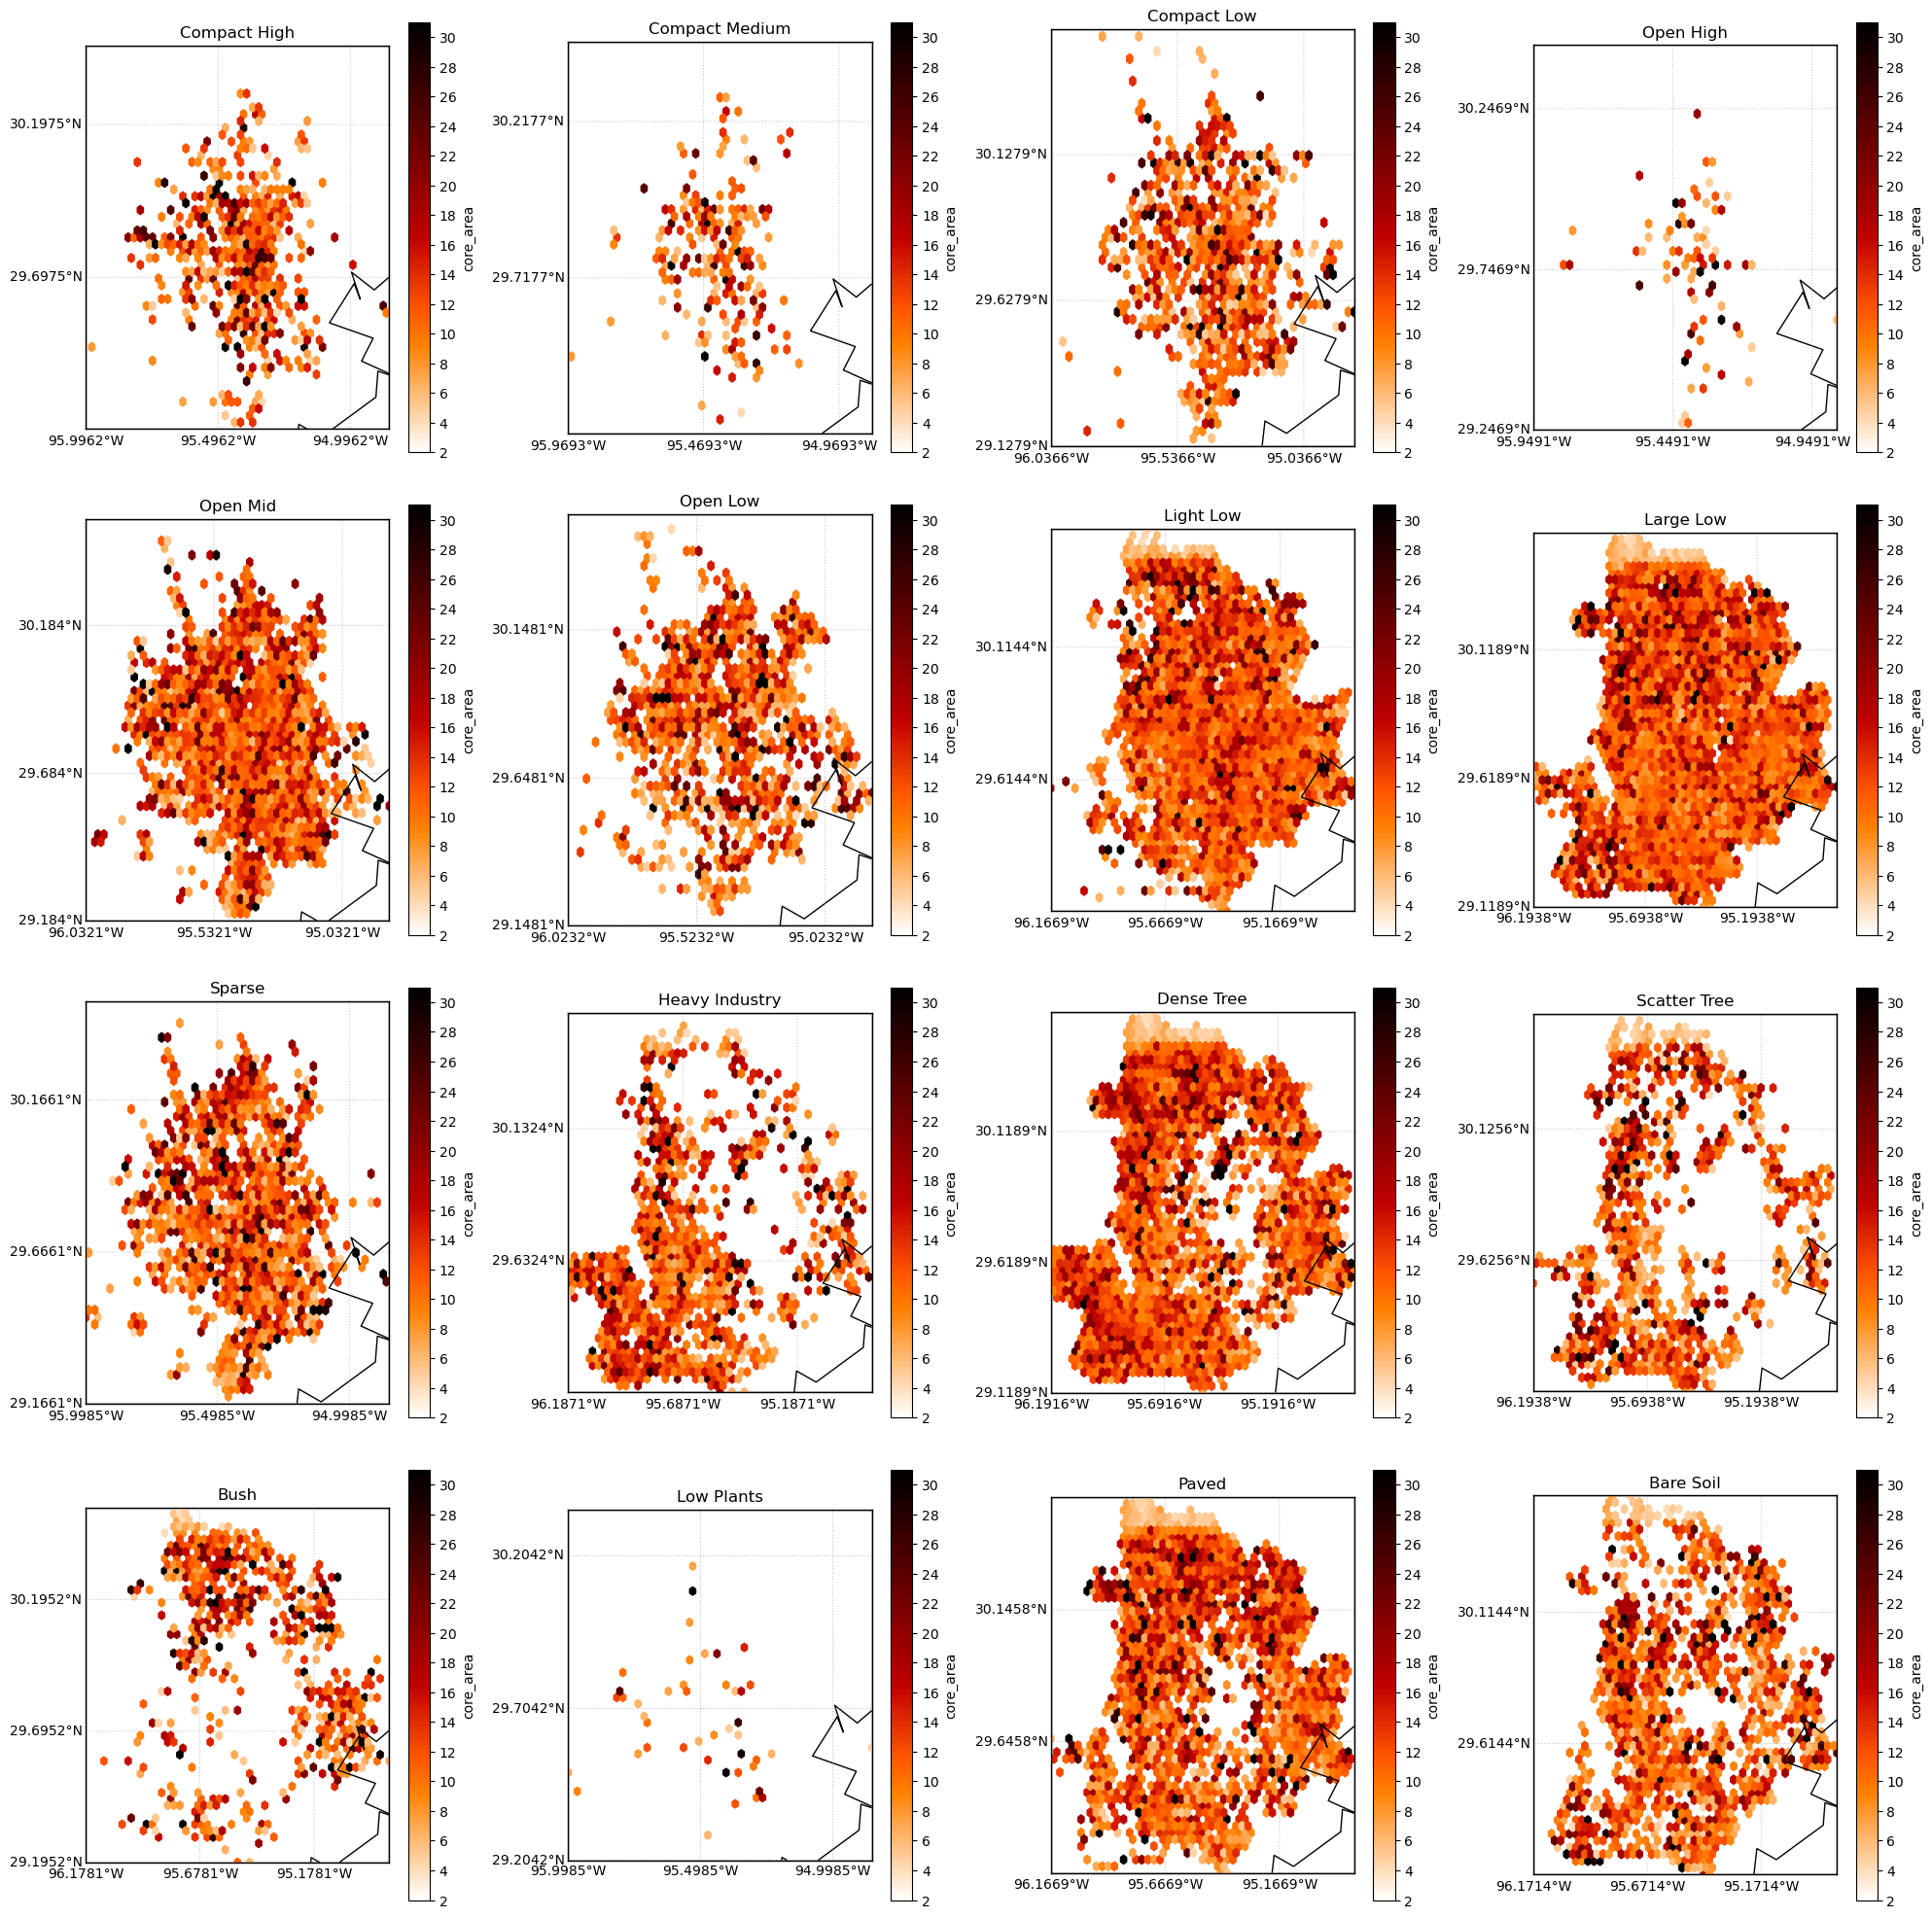

In [73]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from scipy.interpolate import griddata

# Define the grid over which we'll interpolate
grid_resolution = 0.1

# Create a new figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Find global minimum and maximum 'core_area' across all datasets
global_min = 2 # min(pd.read_csv(f'../data/LCZ_classes/class{i}.csv')['core_area'].min() for i in range(1, 17))
global_max = 31 # max(pd.read_csv(f'../data/LCZ_classes/class{i}.csv')['core_area'].max() for i in range(1, 17))

# Define colorbar ticks
ticks = np.arange(global_min, global_max + 1, 2) # ticks from global_min to global_max with a step of 2

# Define class names
class_names = ["Compact High", "Compact Medium", "Compact Low", "Open High", "Open Mid", "Open Low", "Light Low", "Large Low",
               "Sparse", "Heavy Industry", "Dense Tree", "Scatter Tree", "Bush", "Low Plants", "Paved", "Bare Soil", "water"]

# Iterate over class numbers, names and axes
for class_num, class_name, ax in zip(range(1, 17), class_names, axes):
    # Load the data
    data = pd.read_csv(f'../data/LCZ_classes/class{class_num}.csv')

    grid_lons = np.arange(min(data['Longitude']), max(data['Longitude']), grid_resolution)
    grid_lats = np.arange(min(data['Latitude']), max(data['Latitude']), grid_resolution)
    grid_lons, grid_lats = np.meshgrid(grid_lons, grid_lats)

    # Interpolate the data using cubic interpolation
    var_interp = griddata((data['Longitude'], data['Latitude']), data['core_area'], 
                          (grid_lons, grid_lats), method='cubic')

    # Set up the basemap
    m = Basemap(projection='merc', llcrnrlat=data['Latitude'].min(), urcrnrlat=data['Latitude'].max(), 
                llcrnrlon=data['Longitude'].min(), urcrnrlon=data['Longitude'].max(), resolution='l', ax=ax)

    # Convert longitudes and latitudes to map projection coordinates
    x, y = m(data['Longitude'].values, data['Latitude'].values)

    # Create a hexbin plot (2D histogram) of the data
    hb = m.hexbin(x, y, C=data['core_area'].values, gridsize=50, cmap='gist_heat_r', mincnt=1, reduce_C_function=np.mean, vmin=global_min, vmax=global_max)

    # Draw map details
    m.drawmapboundary()
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()

    # Add a colorbar with specific tick locations
    cb = fig.colorbar(hb, ax=ax, pad=0.05, ticks=ticks)
    cb.set_label('core_area')

    # Add labels
    parallels = m.drawparallels(np.arange(data['Latitude'].min(), data['Latitude'].max(), 0.5), labels=[1, 0, 0, 0], 
                                 color='gray', dashes=[1, 3], linewidth=0.5)
    meridians = m.drawmeridians(np.arange(data['Longitude'].min(), data['Longitude'].max(), 0.5), labels=[0, 0, 0, 1], 
                                color='gray', dashes=[1, 3], linewidth=0.5)
    ax.set_title(class_name)  # use the class name instead of the class number

# Display the plot
plt.tight_layout()
plt.show()


In [9]:
np.max(merged_df['core_area'])

276.75

In [7]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.merge(df, merged_df, on='core_area')

# Calculate quartiles for cell_area
df['cell_area_quartiles'] = pd.qcut(df['cell_area'], 4, labels=['Very Small Cells', 'Small Cells', 'Large Cells', 'Very Large Cells'])

In [8]:
# Define lifetime bins
bins = [0, 1, 2, 3, 4, 5, 6]

# Categorize lifetime into bins
df['lifetime_bin'] = pd.cut(df['lifetime'], bins=bins, include_lowest=True)

# Calculate the mean core_area for each lifetime bin and cell_area quartile
df_grouped = df.groupby(['cell_area_quartiles', 'lifetime_bin'])['core_area'].mean().reset_index()

# Convert lifetime_bin to its mid-points
df_grouped['lifetime_mid'] = df_grouped['lifetime_bin'].apply(lambda x: x.mid)

In [9]:
# Initialize a MinMaxScaler
scaler = MinMaxScaler()

# Normalize core_area within each cell_area quartile
df_grouped['core_area_normalized'] = df_grouped.groupby('cell_area_quartiles')['core_area'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).ravel())

# Create a custom color palette
palette = {'Very Small Cells': 'blue', 'Small Cells': 'green', 'Large Cells': 'orange', 'Very Large Cells': 'red'}

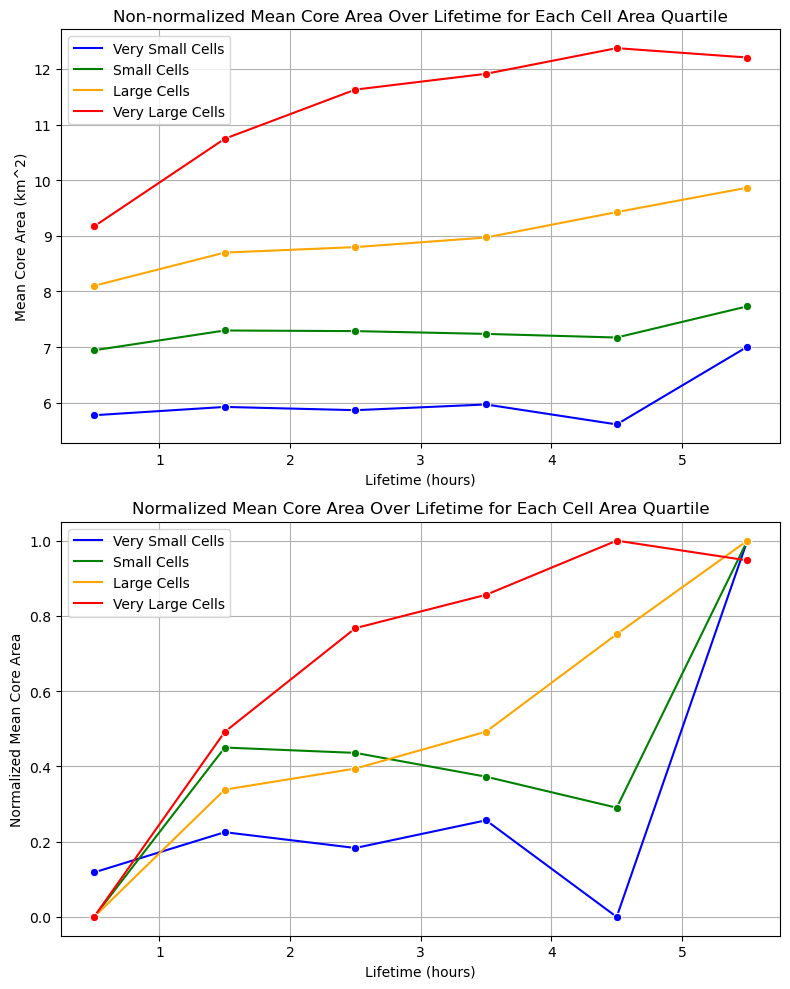

In [10]:
# Create a subplot with 2 rows and 1 column
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Plot the non-normalized data
ax0 = sns.lineplot(ax=axes[0], data=df_grouped, x='lifetime_mid', y='core_area', hue='cell_area_quartiles', palette=palette, marker='o')
ax0.set_title('Non-normalized Mean Core Area Over Lifetime for Each Cell Area Quartile')
ax0.set_xlabel('Lifetime (hours)')
ax0.set_ylabel('Mean Core Area (km^2)')
ax0.grid(True)
ax0.legend(title='')

# Plot the normalized data
ax1 = sns.lineplot(ax=axes[1], data=df_grouped, x='lifetime_mid', y='core_area_normalized', hue='cell_area_quartiles', palette=palette, marker='o')
ax1.set_title('Normalized Mean Core Area Over Lifetime for Each Cell Area Quartile')
ax1.set_xlabel('Lifetime (hours)')
ax1.set_ylabel('Normalized Mean Core Area')
ax1.grid(True)
ax1.legend(title='')

# Adjust the layout
plt.tight_layout()
plt.show()

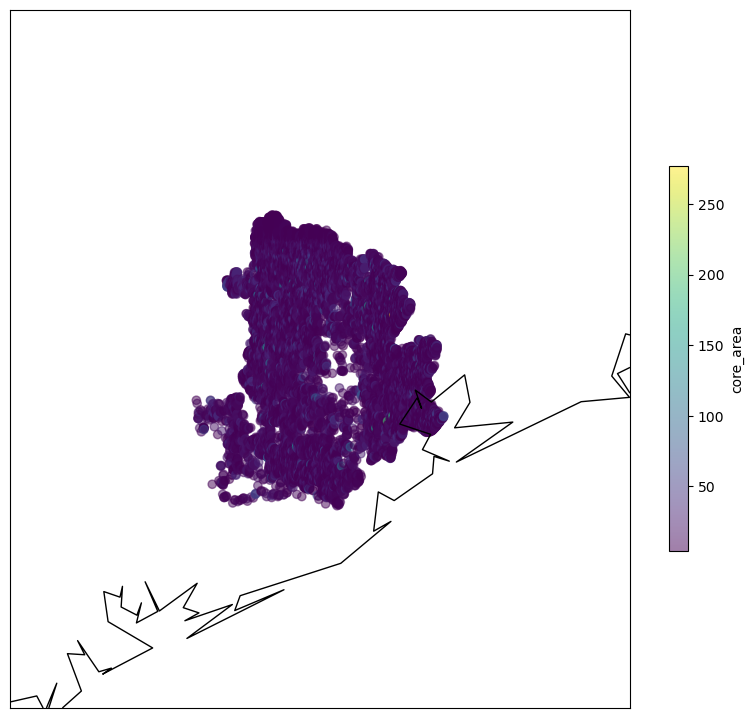

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


import pandas as pd

# Load the data
data = pd.read_csv('class.csv')


# Create a figure and an axes
fig, ax = plt.subplots(figsize=(10, 10))

# Create a map using Basemap
m = Basemap(projection='mill', 
            llcrnrlat = data['Latitude'].min() - 1, 
            urcrnrlat = data['Latitude'].max() + 1, 
            llcrnrlon = data['Longitude'].min() - 1, 
            urcrnrlon = data['Longitude'].max() + 1, 
            resolution='l')

# Draw coastlines and countries
m.drawcoastlines()
m.drawcountries()

# Convert latitudes and longitudes to map coordinates
x, y = m(data['Longitude'].values, data['Latitude'].values)

# Create a scatter plot on the map
scatter = m.scatter(x, y, c=data['core_area'], cmap='viridis', alpha=0.5)

# Add a colorbar
plt.colorbar(scatter, label='core_area', shrink=0.5)

# Display the map
plt.show()


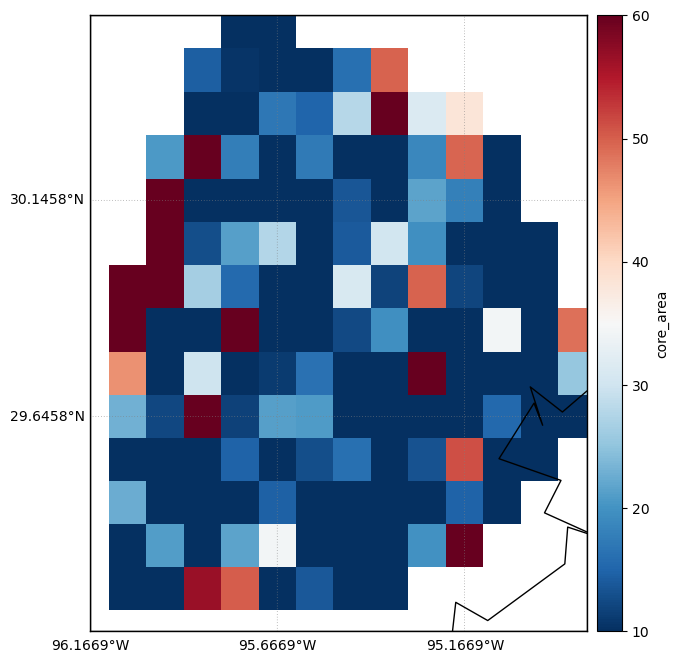